Train Data Shape: torch.Size([10000, 1, 50]), Train Labels Shape: torch.Size([10000])
Test Data Shape: torch.Size([2000, 1, 50]), Test Labels Shape: torch.Size([2000])


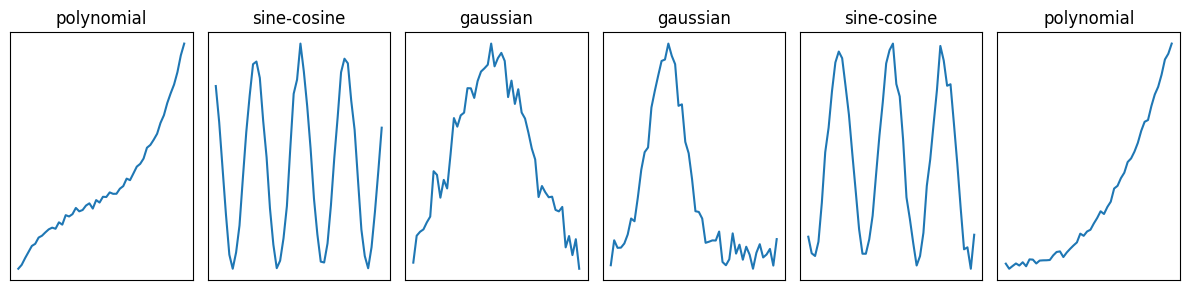

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def generate_function_data(num_samples=5000, num_points=50, err=0.02):
    X = []
    y = []
    functions = ['sine-cosine', 'gaussian', 'polynomial']
    
    for _ in range(num_samples):
        x = np.linspace(-1, 1, num_points)
        func_type = np.random.choice(functions)

        # Initialize a default y_values to prevent UnboundLocalError
        y_values = np.zeros(num_points)
        label = -1

        if func_type == 'sine-cosine':
            freq = np.random.uniform(1, 5)  
            phase = np.random.uniform(0, 2 * np.pi)
            amp = np.random.uniform(0.5, 2)
            y_values = amp * np.sin(freq * np.pi * x + phase) + err * np.random.randn(num_points)
            label = 0

        elif func_type == 'gaussian':
            mu = np.random.uniform(-0.5, 0.5)  
            sigma = np.random.uniform(0.2, 0.5)  
            amp = np.random.uniform(0.5, 2)
            y_values = amp * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + err * np.random.randn(num_points)
            label = 1

        elif func_type == 'polynomial':
            a = np.random.uniform(-2, 2)
            b = np.random.uniform(-2, 2)
            c = np.random.uniform(-3, 3)
            d = np.random.uniform(-0.5, 0.5)
            y_values = a * x**3 + b * x**2 + c * x + d + err * np.random.randn(num_points)
            label = 2

        X.append(y_values)
        y.append(label)

    X = np.array(X).reshape(-1, 1, num_points)  # Add channel dimension
    y = np.array(y)
    
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate a large training and test dataset with adjustable noise
X_train, y_train = generate_function_data(num_samples=10000, err=0.05)  # Low noise in training
X_test, y_test = generate_function_data(num_samples=2000, err=0.2)  # Higher noise in test set

print(f"Train Data Shape: {X_train.shape}, Train Labels Shape: {y_train.shape}")
print(f"Test Data Shape: {X_test.shape}, Test Labels Shape: {y_test.shape}")

plt.figure(figsize=(12, 3))
for i, idx in enumerate(torch.randperm(len(X_train))[:6]):
    plt.subplot(1, 6, i + 1)
    plt.plot(X_train[idx][0].cpu().numpy())
    plt.title(['sine-cosine', 'gaussian', 'polynomial'][y_train[idx].item()])
    plt.xticks([]), plt.yticks([])

plt.tight_layout()
plt.savefig("cnn_data_samples.png", dpi=300)
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class FunctionClassifierCNN(nn.Module):
    def __init__(self):
        super(FunctionClassifierCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 50, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.shape[0], -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = FunctionClassifierCNN()
print(model)

FunctionClassifierCNN(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


Epoch 1/20, Loss: 0.0720
Epoch 2/20, Loss: 0.0159
Epoch 3/20, Loss: 0.0076
Epoch 4/20, Loss: 0.0075
Epoch 5/20, Loss: 0.0052
Epoch 6/20, Loss: 0.0087
Epoch 7/20, Loss: 0.0035
Epoch 8/20, Loss: 0.0019
Epoch 9/20, Loss: 0.0050
Epoch 10/20, Loss: 0.0024
Epoch 11/20, Loss: 0.0027
Epoch 12/20, Loss: 0.0006
Epoch 13/20, Loss: 0.0004
Epoch 14/20, Loss: 0.0117
Epoch 15/20, Loss: 0.0020
Epoch 16/20, Loss: 0.0008
Epoch 17/20, Loss: 0.0003
Epoch 18/20, Loss: 0.0002
Epoch 19/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0001


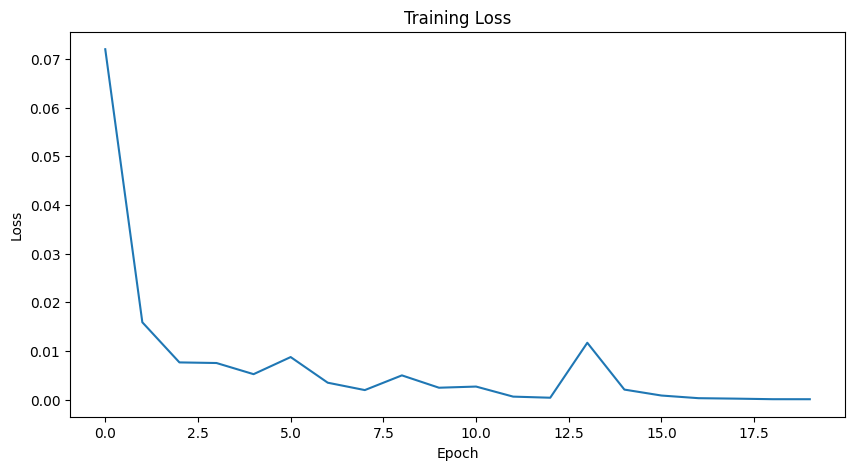

In [3]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
batch_size = 32

# Convert dataset into DataLoader
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)

loss_history = []  # Store loss values

for epoch in range(num_epochs):
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(batch_X), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    loss_history.append(total_loss / len(train_loader))  # Save epoch loss
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_history[-1]:.4f}")

# Plot training loss
fig=plt.figure(figsize=(10,5))
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("cnn_training_loss.png", dpi=300)
plt.show()

In [4]:
# Evaluation
model.eval()
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)

        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.75%


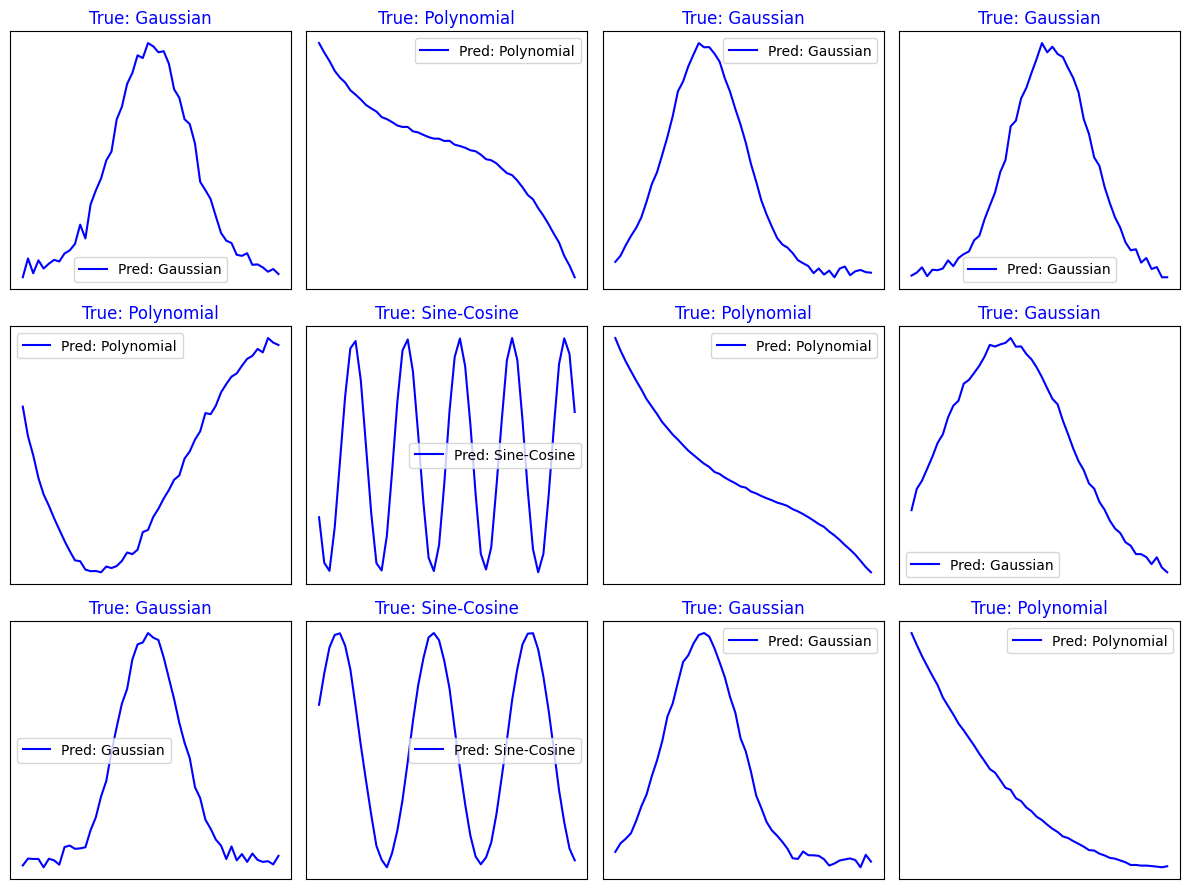

In [6]:
import random
import matplotlib.pyplot as plt

# Generate a few test samples
num_examples = 12  # Show 12 examples
X_new, y_new = generate_function_data(num_samples=num_examples)
X_new = X_new.to(device)

# Get model predictions
model.eval()
with torch.no_grad():
    predictions = model(X_new)
    _, predicted_labels = torch.max(predictions, 1)

# Function names for visualization
func_names = ['Sine-Cosine', 'Gaussian', 'Polynomial']

# Plot the results
rows = num_examples // 4  # Show 4 per row
plt.figure(figsize=(12, 3 * rows))

for i in range(num_examples):
    correct = predicted_labels[i] == y_new[i]  # Check if prediction is correct
    color = 'blue' if correct else 'red'  # Blue for correct, red for incorrect

    plt.subplot(rows, 4, i + 1)
    plt.plot(np.linspace(-1, 1, 50), X_new[i].cpu().numpy().squeeze(), color=color, label=f"Pred: {func_names[predicted_labels[i]]}")
    plt.legend()
    plt.title(f"True: {func_names[y_new[i]]}", color=color)  # Color title for extra clarity
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.savefig("cnn_test_predictions.png", dpi=300)
plt.show()
